In [48]:
#Alex Zhang 512910

In [49]:
# Section1
# 1) Import data and examine a few rows.
# 2) Look at the data types of the variables using dtypes.
# 3) To use them in a model, we need Engine and Power to be numeric. To make them numeric, you
# will need to strip out the text characters and convert the data type to numeric. Use the
# following code:

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [51]:
df1 = pd.read_csv('train.csv')
print(df1.head())
print(df1.dtypes)

df1["Engine"] = df1["Engine"].str.rstrip(" CC")
df1["Power"] = df1["Power"].str.rstrip(" bhp")
df1["Power"] = df1["Power"].replace(regex="null", value=np.nan)
df1["Power"] = df1["Power"].astype(float)
df1["Engine"] = df1["Engine"].astype(float)

                               Name    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010              72000   
1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015              41000   
2                      Honda Jazz V     Chennai  2011              46000   
3                 Maruti Ertiga VDI     Chennai  2012              87000   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013              40670   

  Fuel_Type Transmission Owner_Type     Mileage   Engine      Power  Seats  \
0       CNG       Manual      First  26.6 km/kg   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First  19.67 kmpl  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.2 kmpl  1199 CC   88.7 bhp    5.0   
3    Diesel       Manual      First  20.77 kmpl  1248 CC  88.76 bhp    7.0   
4    Diesel    Automatic     Second   15.2 kmpl  1968 CC  140.8 bhp    5.0   

   New_Price  Price  
0        NaN   1.75  
1        NaN  12.50  
2  8.61 

In [52]:
# 4) Compute some summary statistics of the variables using describe(). Notice that the object
# variables do not appear in the describe() output. What do you notice when you examine the
# summary statistics?

In [53]:
# The summary statistics are provided only for numerical variables. 
# Object variables are excluded from the describe() output. I think that the object variables do not appear in the 
# describe() output. Also, the count is different for some variables, which implies missing values.

In [54]:
#5) Because describe() will not provide information about the object variables, you will need to
#check whether there is missing data in those using a different method. Which variable had the
#most missing values?

In [55]:
missing_data = df1.isnull().sum()
variable_with_most_missing = missing_data.idxmax()
print("Variable with the most missing values:", variable_with_most_missing)

Variable with the most missing values: New_Price


In [56]:
#6) Use pairplot() to examine the distributions and scatterplots of these variables. Do you see
#potential problems such as non-normal or potentially correlated data?

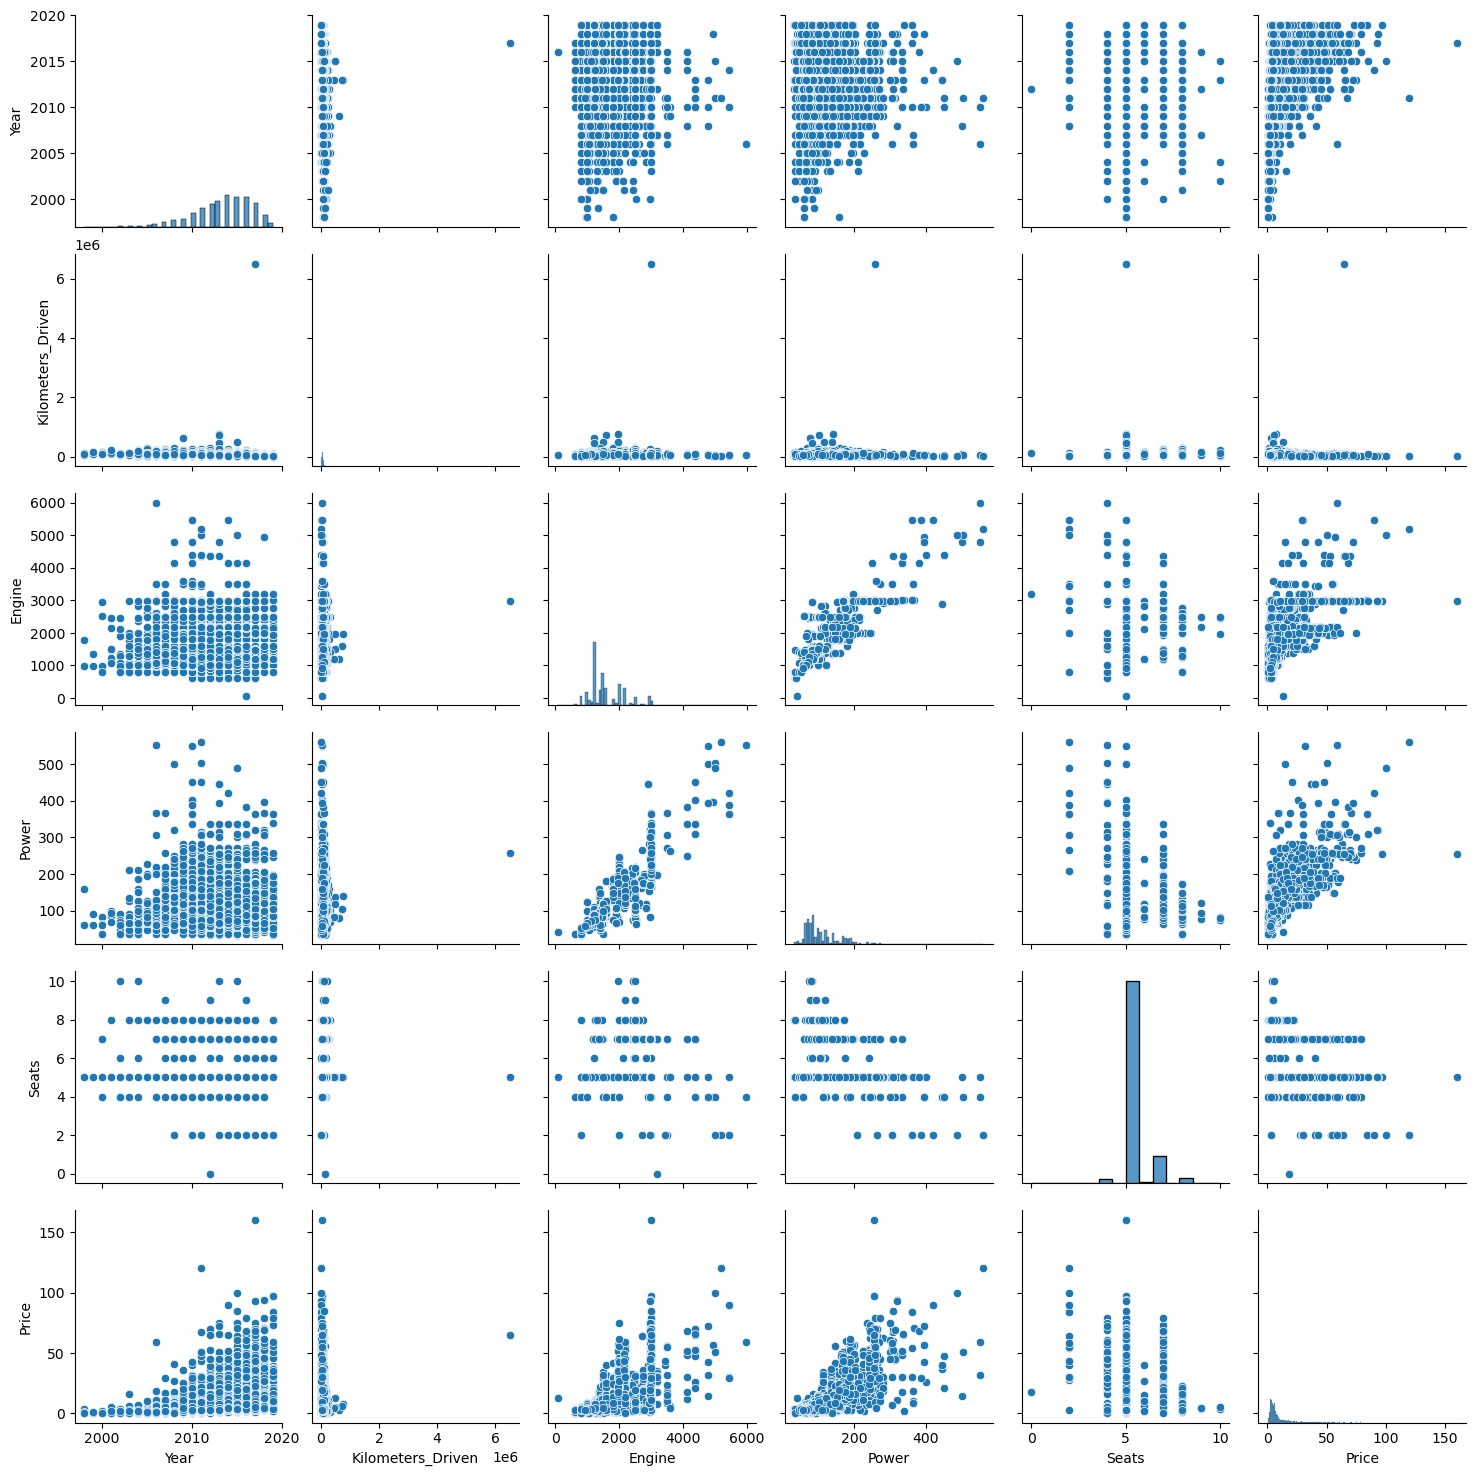

In [57]:
sns.pairplot(df1)
plt.show()

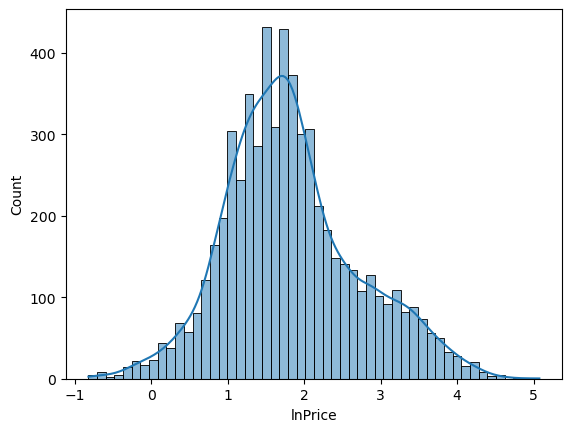

In [58]:
df1['lnPrice'] = np.log(df1['Price'])
sns.histplot(df1['lnPrice'], kde=True)
plt.show()

In [59]:
#Section 2
#1) Build a model of transformed price based on the other 4 variables. Be sure to examine both the
#output and the notes. You will get an error if any of the covariates have missing values.
#a. How much variance is explained?
#b. How many observations were used to fit the model?

In [60]:
df1.dropna(subset=['Power', 'Engine', 'Kilometers_Driven', 'Year', 'lnPrice'], inplace=True)
X = df1[['Power', 'Engine', 'Kilometers_Driven', 'Year']]
y = df1['lnPrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

r_squared = r2_score(y_test, y_pred)
print("Variance explained (R-squared):", r_squared)
print("Number of observations used:", len(y_train))

Variance explained (R-squared): 0.8245757154431794
Number of observations used: 4700


In [61]:
#2) Based on your plots and the note about condition indices in the output, multicollinearity may be
#a problem. Compute the VIF of each variable. Which variables does it show are correlated?

In [62]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

            Variable        VIF
0              Power  21.894782
1             Engine  33.753025
2  Kilometers_Driven   1.425437
3               Year   8.630049


In [63]:
#3) Dimensionality reduction through PCA is one way to manage collinear variables. Use PCA to
#create principal components and create a scree plot. For this example, which criteria would you
#use to determine the number of components to use: proportion of variance, eigenvalues > 1, or
#elbow on the plot?

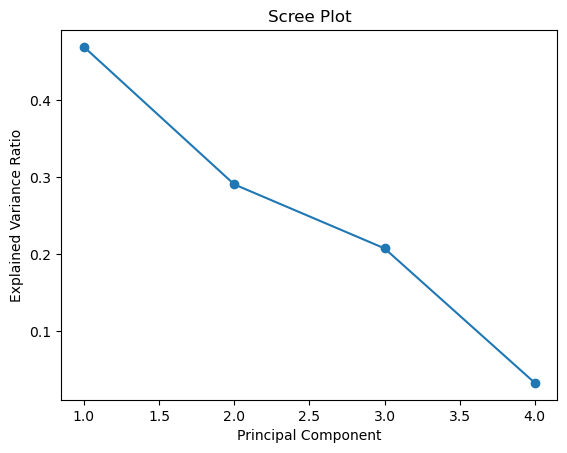

In [64]:
X_std = (X - X.mean()) / X.std()
pca = PCA()
pca.fit(X_std)

explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.show()

In [65]:
#4) Create / select 2 components and rerun the regression with transformed price. What is the
#amount of variance explained?
#a. When merging the transformed price onto the principal components dataframe, you will
#likely need to reset the index.
#b. principalDf = pd.concat([principalDf,
#df1['lnPrice'].reset_index(drop=True)], axis = 1)

In [66]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)
principalDf = pd.concat([pd.DataFrame(X_pca, columns=['PC1', 'PC2']), df1['lnPrice'].reset_index(drop=True)], axis=1)

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
model_pca = LinearRegression()
model_pca.fit(X_pca_train, y_train)

y_pca_pred = model_pca.predict(X_pca_test)

r_squared_pca = r2_score(y_test, y_pca_pred)
print("Variance explained with PCA (R-squared):", r_squared_pca)

Variance explained with PCA (R-squared): 0.7781973152247648


In [67]:
#5) What is the VIF of the components?

In [68]:
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

vif_pca = calculate_vif(pd.DataFrame(X_pca, columns=['PC1', 'PC2']))
print(vif_pca)

  Variable  VIF
0      PC1  1.0
1      PC2  1.0
